### Predicting survival on the Titanic
- Uses the Kaggle dataset found [here](https://www.kaggle.com/competitions/titanic/)

### Imports

In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Data Pre-Processing

In [53]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


drop_cols = ["PassengerId", "Name", "Ticket", "Cabin" ]

# regex.split(r"\d", train_data["Ticket"])
# train_data["Ticket"] = train_data["Ticket"].apply(lambda row: re.split(r"\D", row)[-1])
# train_data["Ticket"] = pd.to_numeric(train_data["Ticket"], errors='coerce').fillna(0).astype(int)
# ticket_data = train_data["Ticket"]
# Normalize the data


# normalized_data = (train_data["Ticket"] - train_data["Ticket"].min()) / (train_data["Ticket"].max() - train_data["Ticket"].min())
# normalized_data = train_data["Ticket"].add()

train_data.drop(drop_cols, axis=1, inplace=True)

# Fill in missing values
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode(), inplace=False)
gender_data = train_data.groupby("Sex")["Age"].mean()
train_data["Age"] = train_data.apply((lambda row: row["Age"] if not pd.isnull(row["Age"]) else gender_data[row["Sex"]]), axis=1)

# Normalize Data: Age, Fare
age_col = train_data["Age"]
train_data["Age"] = (age_col - age_col.min()) / (age_col.max() - age_col.min())
fare_col = train_data["Fare"]
train_data["Fare"] = (fare_col - fare_col.min()) / (fare_col.max() - fare_col.min())

# Standardize Data: Parch, SibSp
parch_col = train_data["Parch"]
train_data["Parch"] = (parch_col - parch_col.mean()) / parch_col.std()
sibsp_col = train_data["SibSp"]
train_data["SibSp"] = (sibsp_col - sibsp_col.mean()) / sibsp_col.std()

# Remove Survived Data
Y = train_data["Survived"]
train_data.drop(["Survived"], axis=1, inplace=True)

# Make Indicator Values for Categorical Data
train_data["Sex"].replace({"male": False, "female": True}, inplace=True)
dummy_cols = ["Pclass", "Sex", "Embarked"]
X = pd.get_dummies(train_data, columns=dummy_cols)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# sr = pd.Series([1, 2, 10, 5, 2,34, 5])
# train_data.plot(subplots=True)
# train_data.hist(bins=20)
# train_data["SibSp"].describe()

### Hyperparameter Testing
Applying 5-Fold Grid Search Cross-Validation to each of the three types of models.

In [40]:
from sklearn import svm

## Kernel, Regularization Parameter, and Degree (for Polynomial Kernel)
# [best value], # [attempted values]
hyperparams_svm = {
    "kernel": ["poly"], # ["linear", "rbf", "sigmoid", "poly"],
    "C": [100], # [0.01, 0.1, 1, 10, 100],
    "degree": [4] # [2, 3, 4, 5, 6]
}

svm_clf = svm.SVC(random_state=0)
gscv_svm = GridSearchCV(svm_clf, hyperparams_svm, verbose=0)
gscv_svm.fit(X_train, Y_train)

accuracy_score(Y_test, gscv_svm.predict(X_test))

0.7988826815642458

In [41]:
from sklearn.neural_network import MLPClassifier

## Activation Function, Solver, Sizes of Hideen Layers, Regularization Parameter
# [best value], # [attempted values]
hyperparams_mlp = {
          "activation" : ["relu"], # ["logistic", "relu", "tanh"],
           # "solver" : ["lbfgs", "sgd", "adam"],
           "hidden_layer_sizes" : [(6, 6, 6)], # [(8,8,8), (6, 6, 6), (6, 6), (4, 4, 4), (4, 4), (12, 12, 12), (12, 12), (12,), (6,), (2,), (5,), (10,), (32,), (32, 32), (50, 50)],
           "alpha" : [1e-5] # [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] 
         }

mlp_clf = MLPClassifier(random_state=0, max_iter=1000)
gscv_mlp = GridSearchCV(mlp_clf, hyperparams_mlp, verbose=1)
gscv_mlp.fit(X_train, Y_train)

accuracy_score(Y_test, gscv_mlp.predict(X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8212290502793296

In [42]:
from sklearn.ensemble import RandomForestClassifier

## Number of Trees, Max Depth
# [best value], # [attempted values]
hyperparams = {
    "n_estimators": [1000], # [100, 500, 1000, 2000, 5000, 10000],
    "max_depth": [5] # [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}

rfc = RandomForestClassifier(random_state=0)
gscv_rfc = GridSearchCV(rfc, hyperparams, verbose=1, scoring="recall")
gscv_rfc.fit(X_train, Y_train)

accuracy_score(Y_test, gscv_rfc.predict(X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8268156424581006

## Accuracy Metrics and Confusion Matrices
The following blocks show the accuracies of the models and the confusion matrices to show actual vs. predicted values

Accuracy:  0.7988826815642458


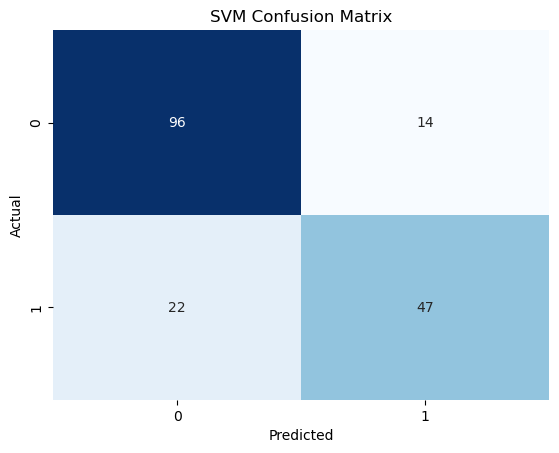

In [43]:
acc = gscv_svm.score(X_test, Y_test)
print("Accuracy: ", acc)
cm = confusion_matrix(Y_test, gscv_svm.predict(X_test))

sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.savefig("metrics/svm_confusion_matrix.png") 
plt.show()
# Pulled from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Accuracy:  0.8212290502793296


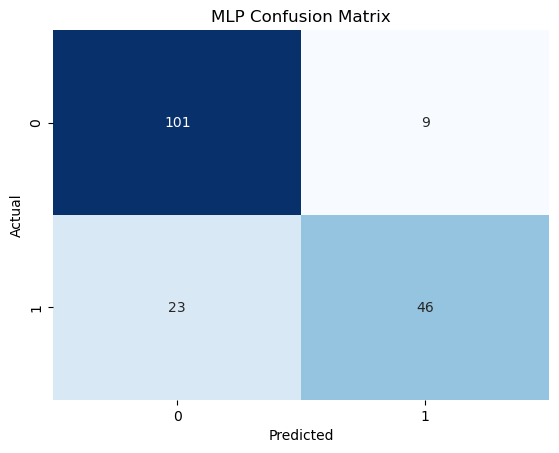

In [44]:
acc = gscv_mlp.score(X_test, Y_test)
print("Accuracy: ", acc)
cm = confusion_matrix(Y_test, gscv_mlp.predict(X_test))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Confusion Matrix")
plt.savefig("metrics/mlp_confusion_matrix.png")
plt.show()
# Pulled from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Accuracy:  0.6811594202898551


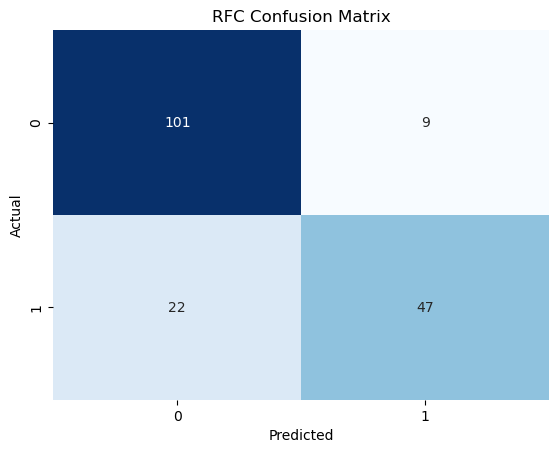

In [45]:
acc = gscv_rfc.score(X_test, Y_test)
print("Accuracy: ", acc)
cm = confusion_matrix(Y_test, gscv_rfc.predict(X_test))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RFC Confusion Matrix")
plt.savefig("metrics/rfc_confusion_matrix.png")
plt.show()
# Pulled from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

## Fitting all training data using best hyperparameters from cross validation
Displaying only the accuracy of the model

### SVM

In [46]:
model_svm_params = gscv_svm.best_params_
model_svm = svm.SVC(**model_svm_params, random_state=0)
model_svm.fit(X, Y)
accuracy_score(Y_test, model_svm.predict(X_test))

0.8715083798882681

### MLP

In [47]:
# Multi-Layer Perceptron Model
model_mlp_params = gscv_mlp.best_params_
model_mlp = MLPClassifier(**model_mlp_params, random_state=0, max_iter=1000)
model_mlp.fit(X, Y)
accuracy_score(Y_test, model_mlp.predict(X_test))

0.8268156424581006

### Random Forest

In [48]:
model_rfc_params = gscv_rfc.best_params_
model_rfc = RandomForestClassifier(**model_rfc_params, random_state=0)
model_rfc.fit(X, Y)
accuracy_score(Y_test, model_rfc.predict(X_test))

0.8547486033519553

## Fitting the Test Data
Performing the same data pre-processing to the test data, with the addition that the missing values of Fare are filled in with the average fare cost

In [49]:
## Data Cleanup
# Remove columns that are not useful
test_data = pd.read_csv('test.csv')

passid_cols = test_data.PassengerId
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
test_data.drop(drop_cols, axis=1, inplace=True)

# Fill in missing values
test_data["Embarked"] = test_data["Embarked"].fillna(test_data["Embarked"].mode(), inplace=False)
gender_data = test_data.groupby("Sex")["Age"].mean()
test_data["Age"] = test_data.apply((lambda row: row["Age"] if not pd.isnull(row["Age"]) else gender_data[row["Sex"]]), axis=1)
test_data["Fare"] = test_data["Fare"].fillna(test_data["Fare"].mean(), inplace=False)


# Normalize Data: Age, Fare
age_col = test_data["Age"]
test_data["Age"] = (age_col - age_col.min()) / (age_col.max() - age_col.min())
fare_col = test_data["Fare"]
test_data["Fare"] = (fare_col - fare_col.min()) / (fare_col.max() - fare_col.min())


# Standardize Data: Parch, SibSp
parch_col = test_data["Parch"]
test_data["Parch"] = (parch_col - parch_col.mean()) / parch_col.std()
sibsp_col = test_data["SibSp"]
test_data["SibSp"] = (sibsp_col - sibsp_col.mean()) / sibsp_col.std()

# Make Indicator Values for Categorical Data
test_data["Sex"].replace({"male": False, "female": True}, inplace=True)
dummy_cols = ["Pclass", "Sex", "Embarked"]
X_testing = pd.get_dummies(test_data, columns=dummy_cols)

In [52]:
models = [model_svm, model_mlp, model_rfc]
model_names = ["SVM", "MLP", "RFC"]

for model, name in zip(models, model_names):
    predictions = model.predict(X_testing)
    output = pd.DataFrame({'PassengerId': passid_cols, 'Survived': predictions})
    output.to_csv(f'results/{name}_submission.csv', index=False)

